In [1]:
import io
import tools.parse as parse
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import pandas as pd
import plotly.io as pio
from IPython.display import display
from matplotlib.ticker import MultipleLocator

In [2]:
def interactive_maw_viewer_ipy(maw_data, e_max_data, P_value, raw_data):
    print(len(maw_data), len(e_max_data))
    if not maw_data or not e_max_data:
        print("No data to display")
        return

    e_max_data = np.array(e_max_data)
    unique_e = np.unique(e_max_data)
    maw_data = np.array(maw_data, dtype=object)

    slider = widgets.SelectionSlider(
        options=sorted(unique_e),
        value=unique_e[0],
        description='e_max:',
        continuous_update=False
    )

    output = widgets.Output()

    def plot_maws(e_val):
        with output:
            output.clear_output(wait=True)
            matching_indices = np.where(e_max_data == e_val)[0]
            num_matches = len(matching_indices)
            print(f"{num_matches} event(s) with e_max = {e_val}")

            if num_matches == 0:
                print("No matching events.")
                return

            fig, ax = plt.subplots(1, 2, figsize=(20, 5))
            for idx in matching_indices:
                # ax.plot(np.array(maw_data[idx]) - 134217728, alpha=0.5)
                ax[0].plot(np.array(maw_data[idx]), alpha=0.5)
            if len(raw_data) > 0:
                for idx in matching_indices:
                    ax[1].plot(raw_data[idx], alpha=0.5)
            ax[0].set_title(f"{num_matches} Events | e_max = {e_val} | e_max (original) = {e_val * P_value}")
            ax[0].set_xlabel("Clock ticks")
            ax[0].set_ylabel("ADC value")
            
            ax[0].axvline(x=50+P_value, color='k', linestyle='--', linewidth=0.5, label='E_max')
            ax[0].axvline(x=50+P_value+50, color='k', linestyle='--', linewidth=0.5, label='E_max')
            ax[0].axvline(x=50+70 + 234, color='r', linestyle='--', linewidth=0.5, label='E_max')
            ax[0].axhline(y=e_val * P_value, color='k', linestyle='--', linewidth=0.5)

            ax[0].xaxis.set_major_locator(MultipleLocator(50))
            ax[0].xaxis.set_minor_locator(MultipleLocator(20))
            ax[0].grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
            ax[0].grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
            ax[0].minorticks_on()

            ax[1].xaxis.set_major_locator(MultipleLocator(50))
            ax[1].xaxis.set_minor_locator(MultipleLocator(20))
            ax[1].grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
            ax[1].grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
            ax[1].minorticks_on()

            ax[0].set_ylim(np.min(maw_data) - 10 * P_value, np.max(maw_data) + 10 * P_value)
            
            plt.show()

    widgets.interact(plot_maws, e_val=slider)
    display(output)

In [ ]:
from scipy.ndimage import gaussian_filter1d

def parse_events(file, debug=False, verbose=False, save_raw=False):
    infile = io.open(file, 'rb')
    p = parse.Parse(infile)
    event_raw = []
    event_maw = []
    e_max = []
    e_max_corrected = []
    e_start = []
    timestamp = []
    true_time = []
    peak = []
    maw_max = []
    totalEvents = 0

    P_value = 50

    # N = 2000
    N = 2000000

    if save_raw:
        N = 1500000

    HARDCODED_STOP = 2000 # Prevents over plotting of raw adc scope signals

    if save_raw:
        HARDCODED_STOP = 1500000
        chunk_size=10000
        chunk_id = 0
        event_chunk = []
    
    for eventNum, event in enumerate(p):
        if eventNum > N:
            break    
        if save_raw and eventNum < HARDCODED_STOP and hasattr(event, 'raw'):
            event_chunk.append(event.raw)
            if len(event_chunk) == chunk_size:
                chunk_filename = f"{file.replace('.dat','')}_raw_chunk{chunk_id:03d}.npy"
                np.save(chunk_filename, np.array(event_chunk))
                chunk_id += 1
                event_chunk = []
            continue

        timestamp.append(event.ts)
        true_time.append( event.ts/(250_000_000) )
        totalEvents = eventNum
        if hasattr(event,'e_max'):
            if event.e_start < 0:
                e_max_corrected.append(int((event.e_max - event.e_start) / P_value))
                e_max.append(int(event.e_max / P_value))
            else:
                e_max_corrected.append(int((event.e_max) / P_value))
                e_max.append(int(event.e_max / P_value))
        if hasattr(event, 'e_start'):
            e_start.append(int(event.e_start / P_value))
        if hasattr(event,'peak'):
            peak.append(event.peak)
        if hasattr(event,'maw_max'):
            maw_max.append(event.maw_max)
        if verbose and eventNum<HARDCODED_STOP:
            if hasattr(event,'fmt'):
                print('format', bin(event.fmt))
            if hasattr(event,'peak'):
                print('peak ',event.peak)
            if hasattr(event,'e_max'):
                print('e_max ',event.e_max)
            if hasattr(event, 'acc7'):
                print('acc7 ', event.acc7)
            if hasattr(event, 'acc8'):
                print('acc8 ', event.acc8)
            if hasattr(event,'maw_max'):
                print('maw_max ',event.maw_max)
        if eventNum<HARDCODED_STOP and hasattr(event,'raw'):
            event_raw.append( event.raw )
        if eventNum<HARDCODED_STOP and hasattr(event,'maw'):
            event_maw.append( event.maw )

    if save_raw and event_chunk:
        chunk_filename = f"{file.replace('.dat','')}_raw_chunk{chunk_id:03d}.npy"
        np.save(chunk_filename, np.array(event_chunk))
    
    print('Total events: ', totalEvents+1)

    if debug:
        plt.figure()
        plt.title( 'Time hist' )
        timeHist, bin_edges = np.histogram( true_time, 
                                    range=[ int(true_time[0]), int(np.ceil(true_time[-1])) ],
                                    bins = int(np.ceil(true_time[-1]  ) ) )
        plt.step( (bin_edges[1:] + bin_edges[:-1])/2 , timeHist )

    if event_raw: 
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        ax[0].set_title('raw')
        ax[1].set_title('gradient')
        ax[0].set_xlabel('Clock ticks')
        ax[1].set_xlabel('Clock ticks')
        for i, raw in enumerate(event_raw):    
            if i > 20:
                break
            # ax[0].plot(raw, color=f'C{i%10}')
            raw_smooth = gaussian_filter1d(raw, sigma=1) 
            ax[0].plot(raw_smooth, color=f'C{i%10}')
            ax[1].plot(np.gradient(raw_smooth), color=f'C{i%10}')

        # ax[1].set_xlim(150, 400)
        # ax[0].set_xlim(150, 400)
        # ax[1].set_ylim(-5, 15)
    
    if event_maw:
        fig, (ax) = plt.subplots(1, 1, figsize=(10, 5))
        # plt.figure()
        ax.set_title('maw')
        ax.set_xlabel('Clock ticks')
        for i, maw in enumerate(event_maw):
            # if e_max[i] < 600 or e_max[i] > 1100:
            #     continue
            ax.plot(np.array(maw) - 134217728, color=f'C{i%10}')
        # plt.axhline(400+0x800_0000, color='black')
 
    if debug:
        plt.figure()
        plt.title('Event spacing')
        plt.xlabel('timestamp2 - timestamp1 [clock ticks]')
        plt.ylabel('Num events')
        spacing = np.subtract(timestamp[1:], timestamp[:-1])
        eventSpacingHist, bin_edges = np.histogram(spacing, range=[ 0, 100000], 
                                                    bins=10000)
        
        # print( 'number of events where spacing is between [1000,2000] clock ticks')
        # print( ((1000 < spacing) & (spacing < 2000)).sum() )
        plt.plot( (bin_edges[1:] + bin_edges[:-1])/2 , eventSpacingHist )
        #plt.axvline(1000, label='Trigger window length (1000)', color='gray')
        # plt.xlim(0, np.amax(spacing))
        # plt.ylim(0)
        #plt.legend()

        print('Average event spacing ', np.mean(spacing))


    if maw_max:
        plt.figure()
        plt.title('MAW max')
        plt.xlabel('Maw max')
        plt.ylabel('Num events')
        plt.hist(maw_max, range=[ np.amin(maw_max), np.amax(maw_max)], bins=int(np.amax(maw_max)-np.amin(maw_max)) )
        plt.xlim(np.amin(maw_max), np.amax(maw_max))

    if e_max:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
        ax[0].set_title('sis3316 E_max')
        ax[0].set_xlabel('bin number (e_max / G)')
        ax[0].set_ylabel('Num events')
        ax[0].hist(e_max, range=[ np.amin(e_max), np.amax(e_max)],  bins=int(np.amax(e_max)-np.amin(e_max)) )
        ax[0].set_yscale('log')

        ax[1].set_title('sis3316 E_max Corrected')
        ax[1].set_xlabel('bin number (e_max / G)')
        ax[1].set_ylabel('Num events')
        ax[1].hist(e_max_corrected, range=[ np.amin(e_max_corrected), np.amax(e_max_corrected)],  bins=int(np.amax(e_max_corrected)-np.amin(e_max_corrected)) )
        ax[1].set_yscale('log')
        plt.xlim(0,1850)
        plt.show()

        plt.figure(figsize=(10, 5), dpi=150)
        plt.title('sis3316 E_max Comparison')
        plt.xlabel('bin number (e_max / G)')
        plt.ylabel('Num events')
        plt.hist(e_max_corrected, range=[ np.amin(e_max_corrected), np.amax(e_max_corrected)],  bins=int(np.amax(e_max_corrected)-np.amin(e_max_corrected)), label="Corrected", alpha=0.5 )
        plt.hist(e_max, range=[ np.amin(e_max), np.amax(e_max)],  bins=int(np.amax(e_max)-np.amin(e_max)), label='Original', alpha=0.5 )
        plt.yscale('log')
        plt.legend()
        plt.show()

    if e_start and debug:
        plt.figure(figsize=(10, 5), dpi=150)
        plt.title('sis3316 E_start')
        plt.xlabel('bin number (e_max / G)')
        plt.ylabel('Num events')
        plt.hist(e_start, range=[ np.amin(e_start), np.amax(e_start)],  bins=int(np.amax(e_start)-np.amin(e_start)) )
        # plt.hist(e_max, range=[ np.amin(e_max), np.amax(e_max)],  bins=1000 )
        plt.yscale('log')
        # plt.ylim(0, 550)
        plt.show()


    if event_maw:
        interactive_maw_viewer_ipy(event_maw, e_max[:N], P_value, event_raw)

    return

Total events:  456575


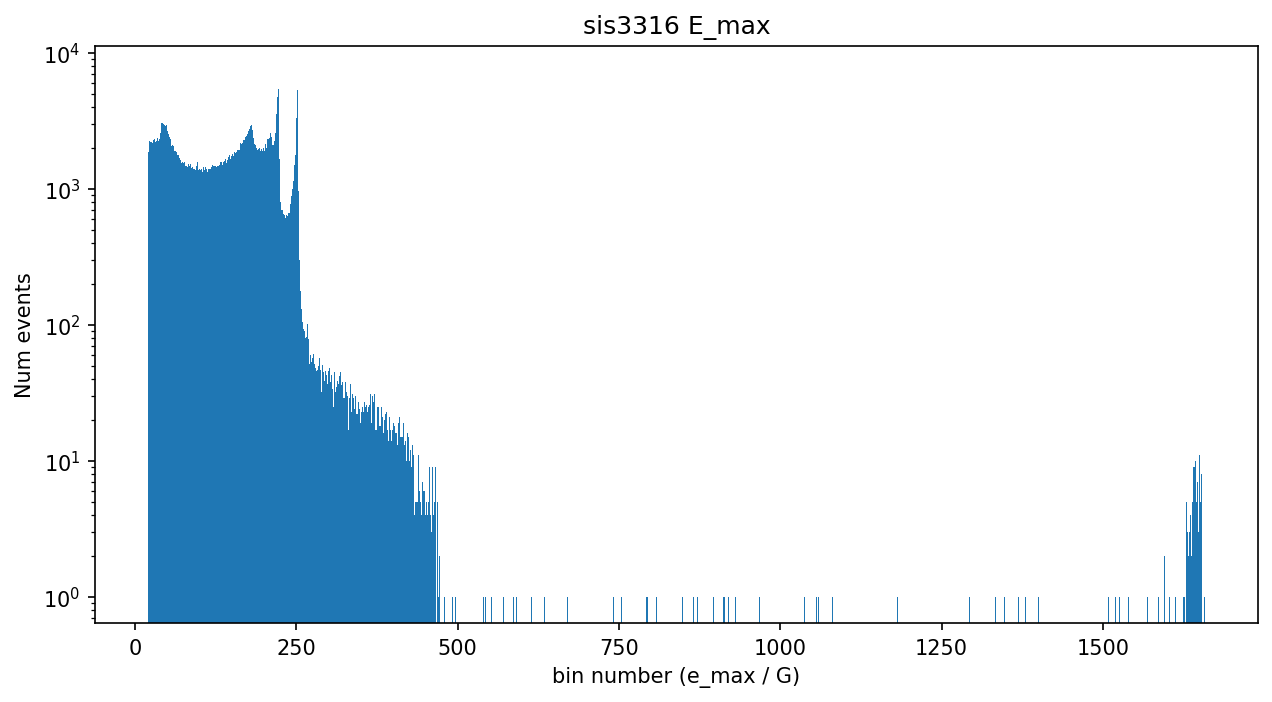

In [13]:
filename = "./Tests/20250220_run19/ch00.dat"
parse_events(filename)

Total events:  501289


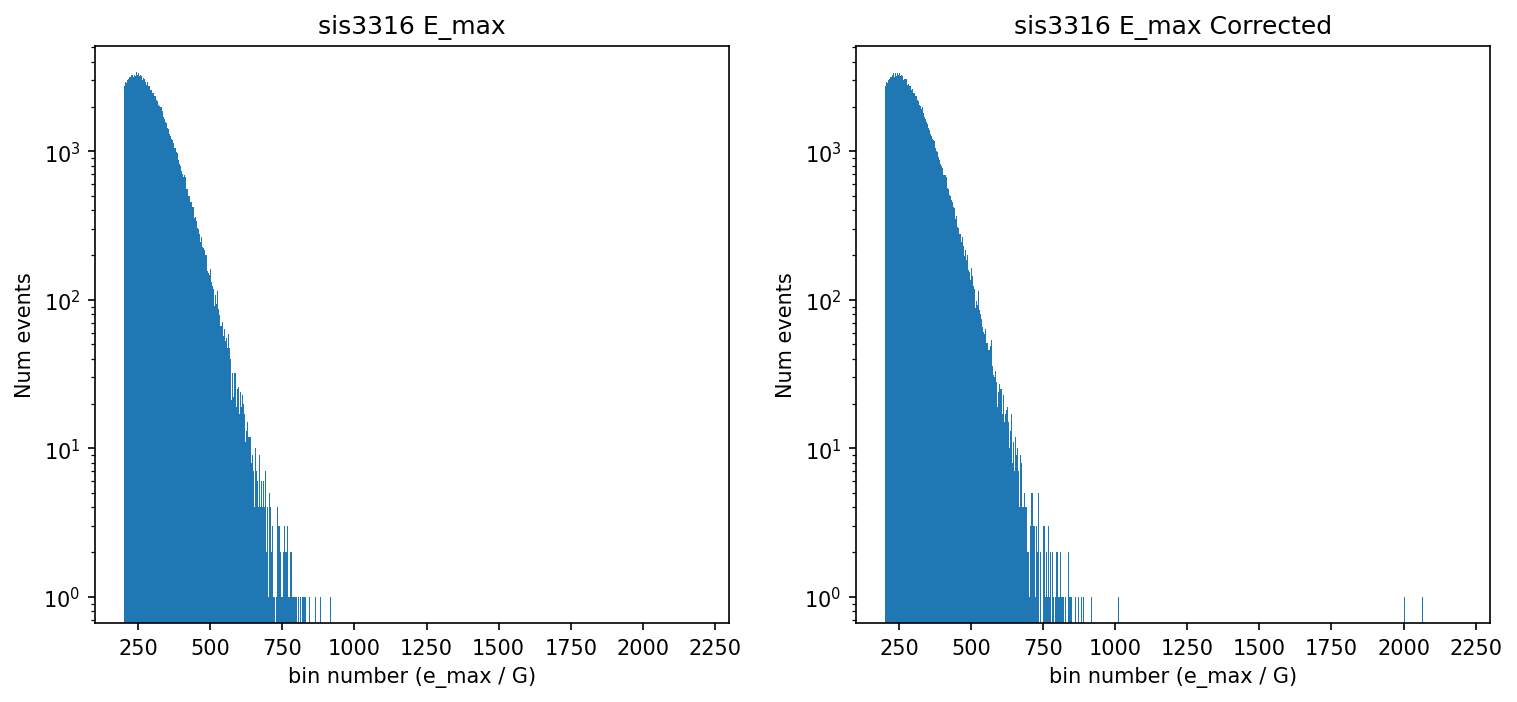

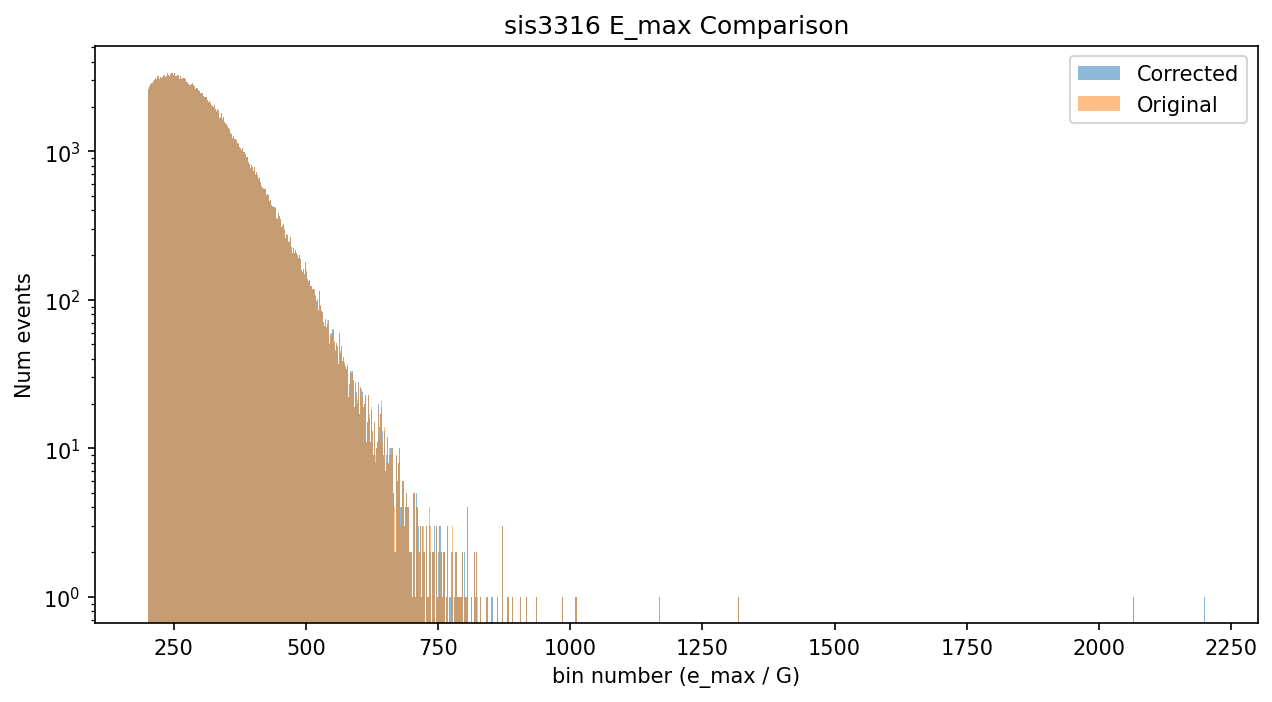

In [4]:
filename = "./Tests/20250616_run18/ch00.dat"
parse_events(filename, debug=False, save_raw=False)

Total events:  641931


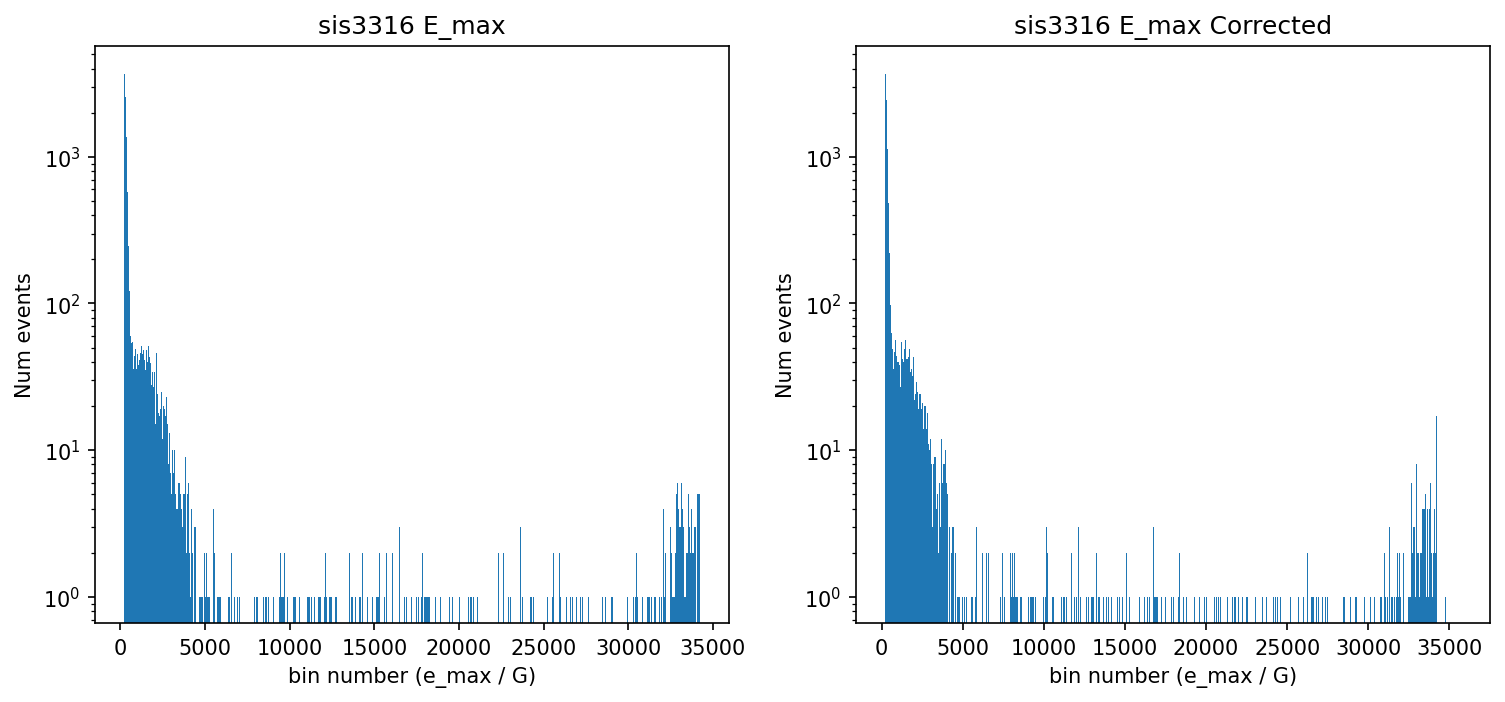

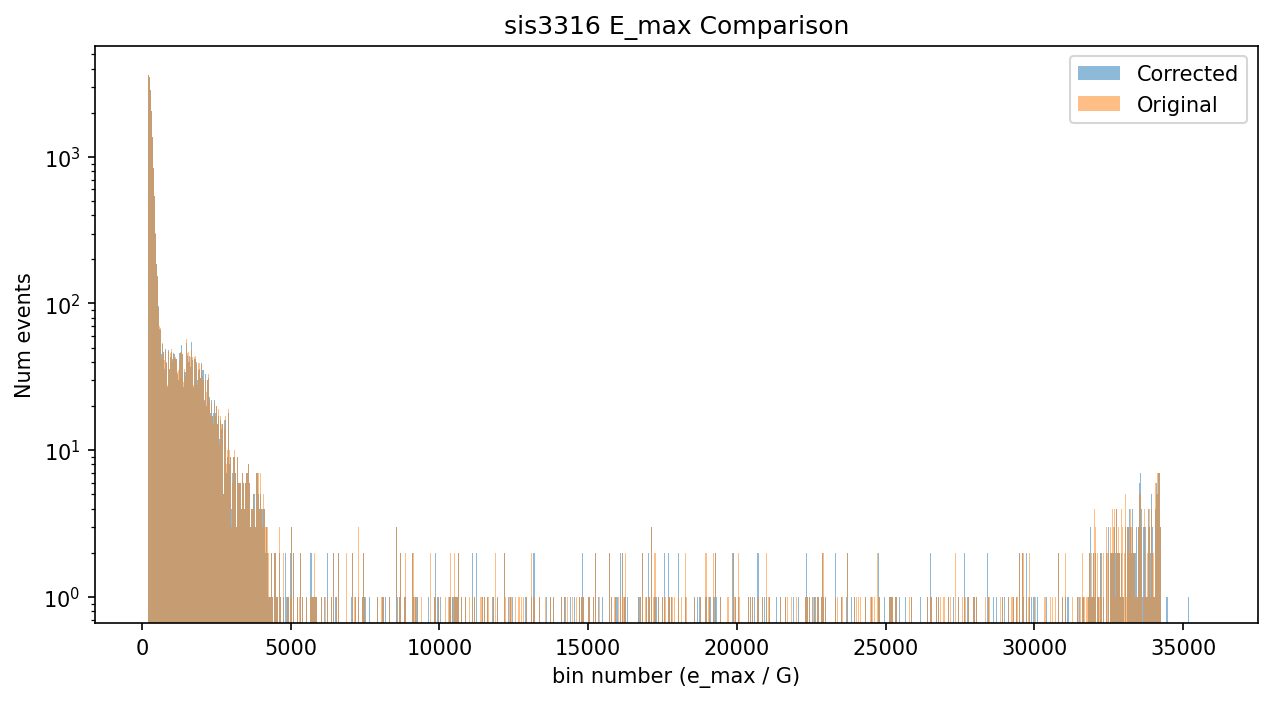

In [6]:
filename = "./Tests/20250616_run19/ch00.dat"
parse_events(filename, debug=False, save_raw=False)

Total events:  72358
Average event spacing  2500.1415343366916


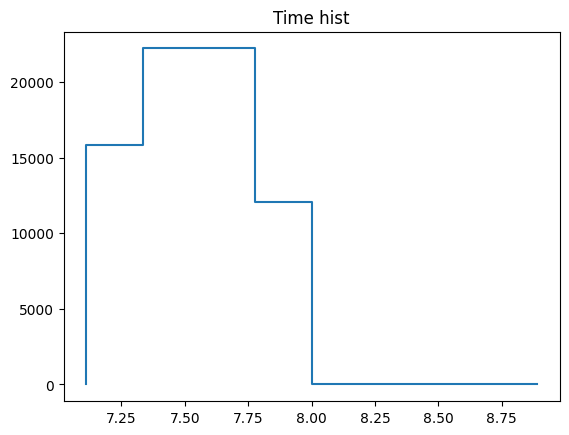

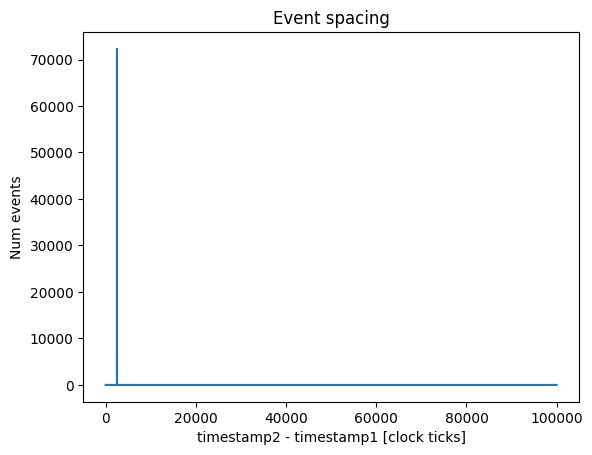

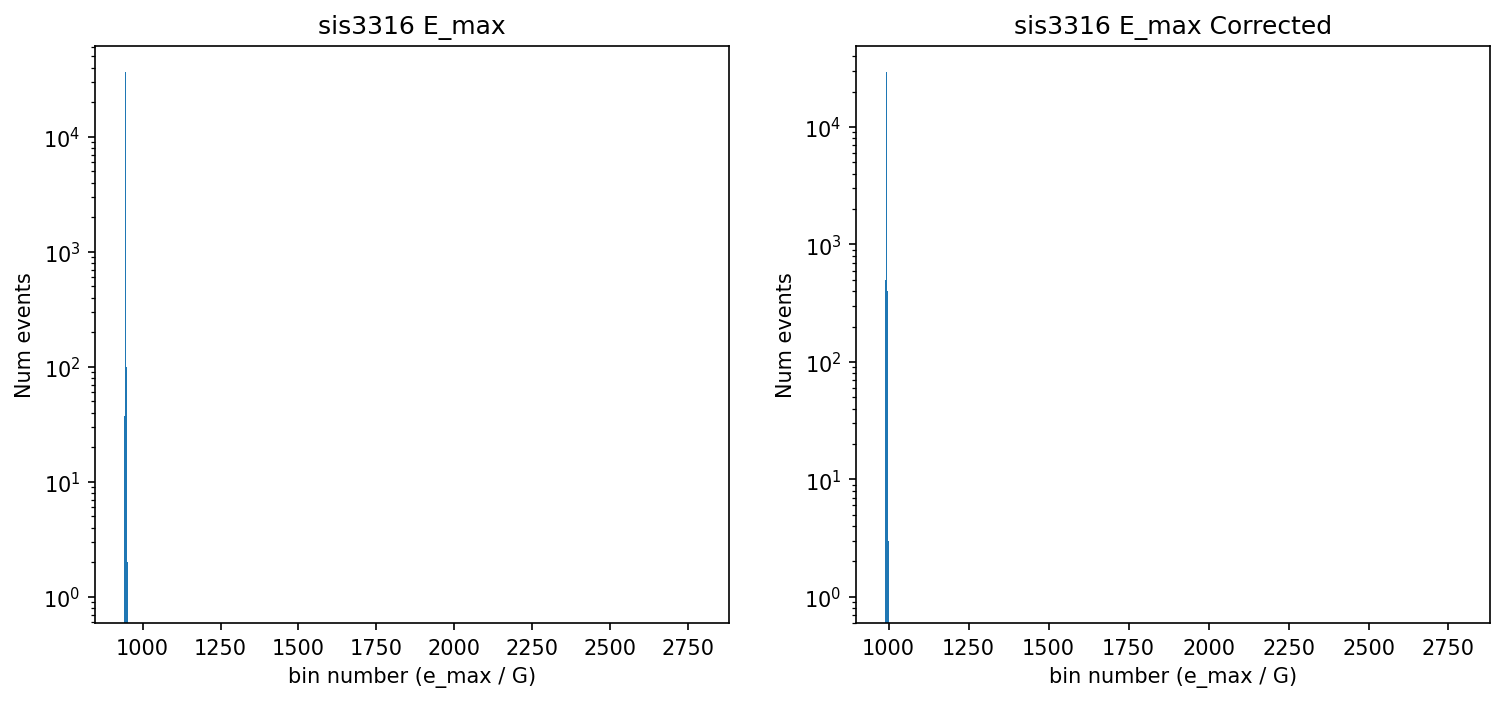

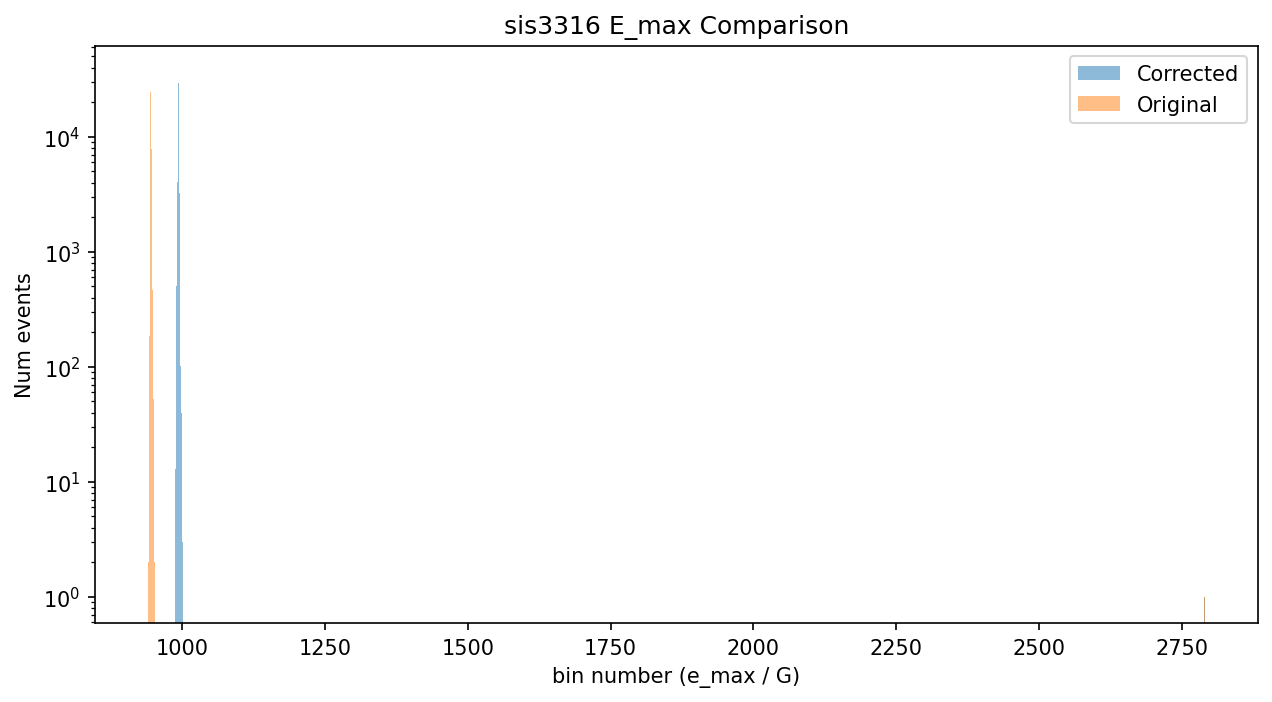

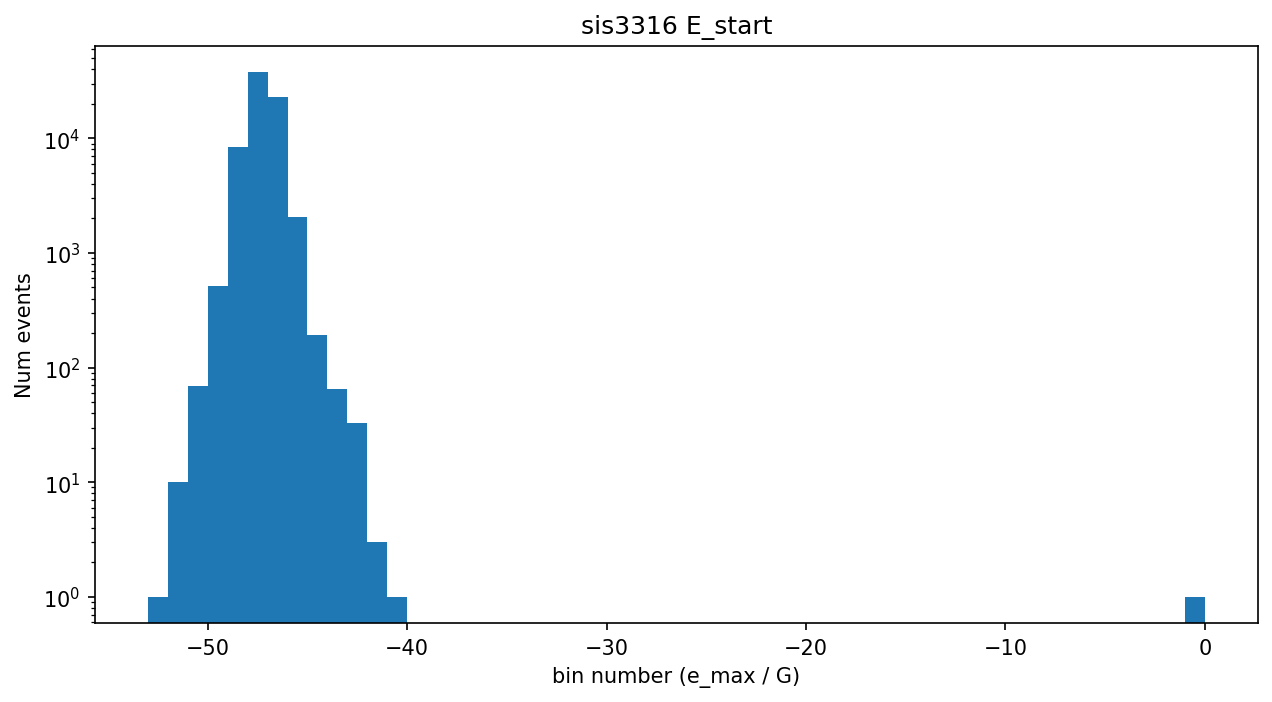

In [40]:
filename = "./Tests/20250616_run5/ch03.dat"
parse_events(filename, debug=True, save_raw=False)

Total events:  666859
Average event spacing  2500.146169049483


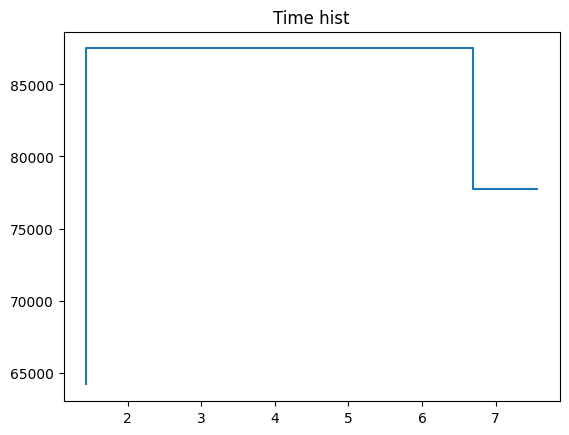

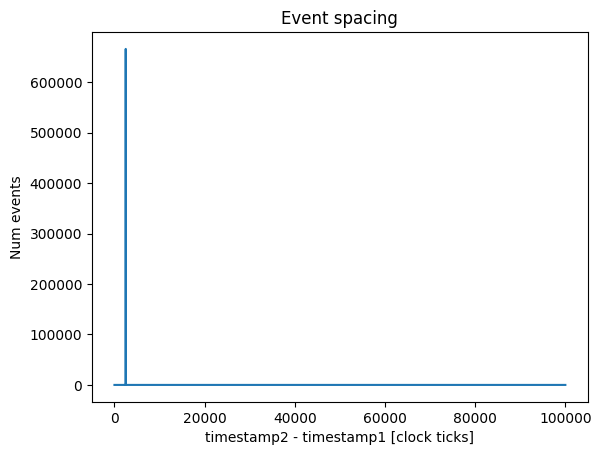

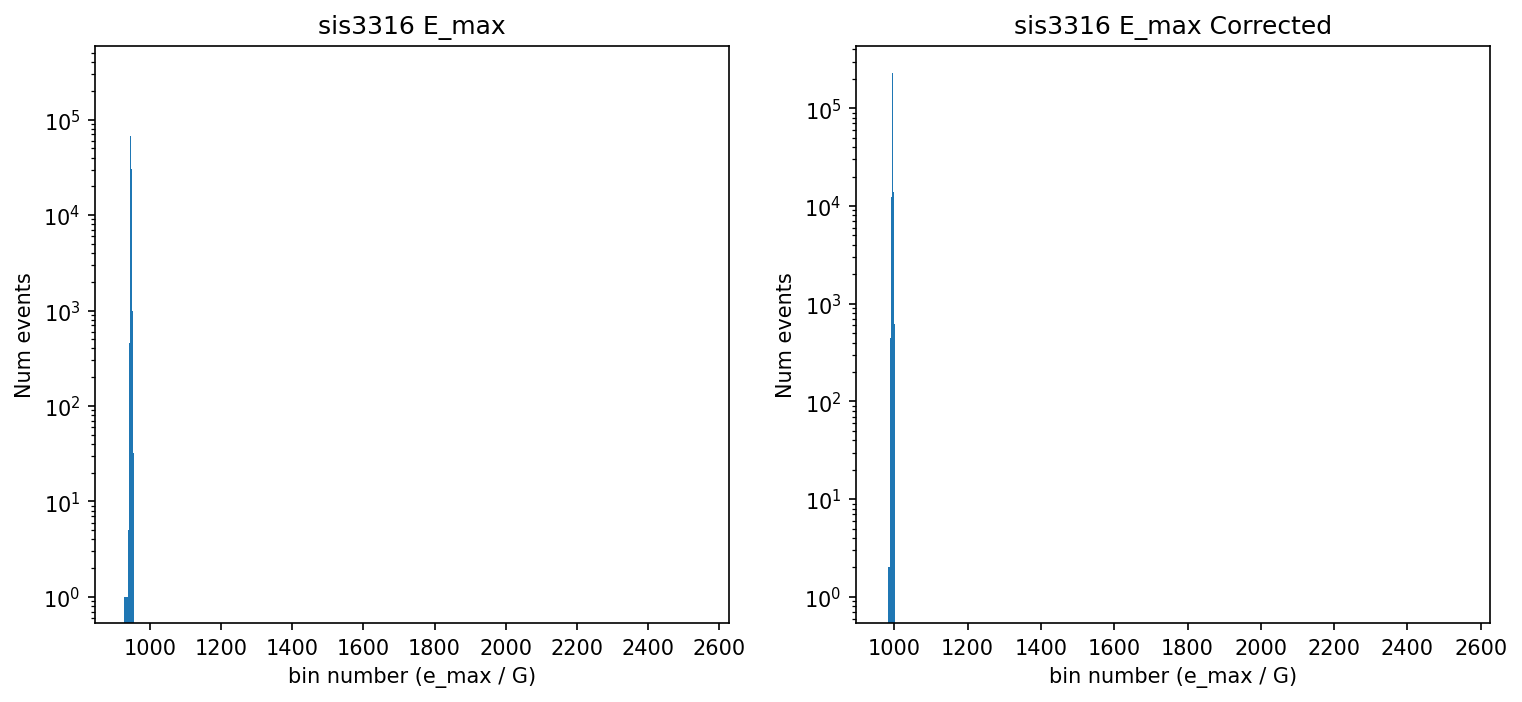

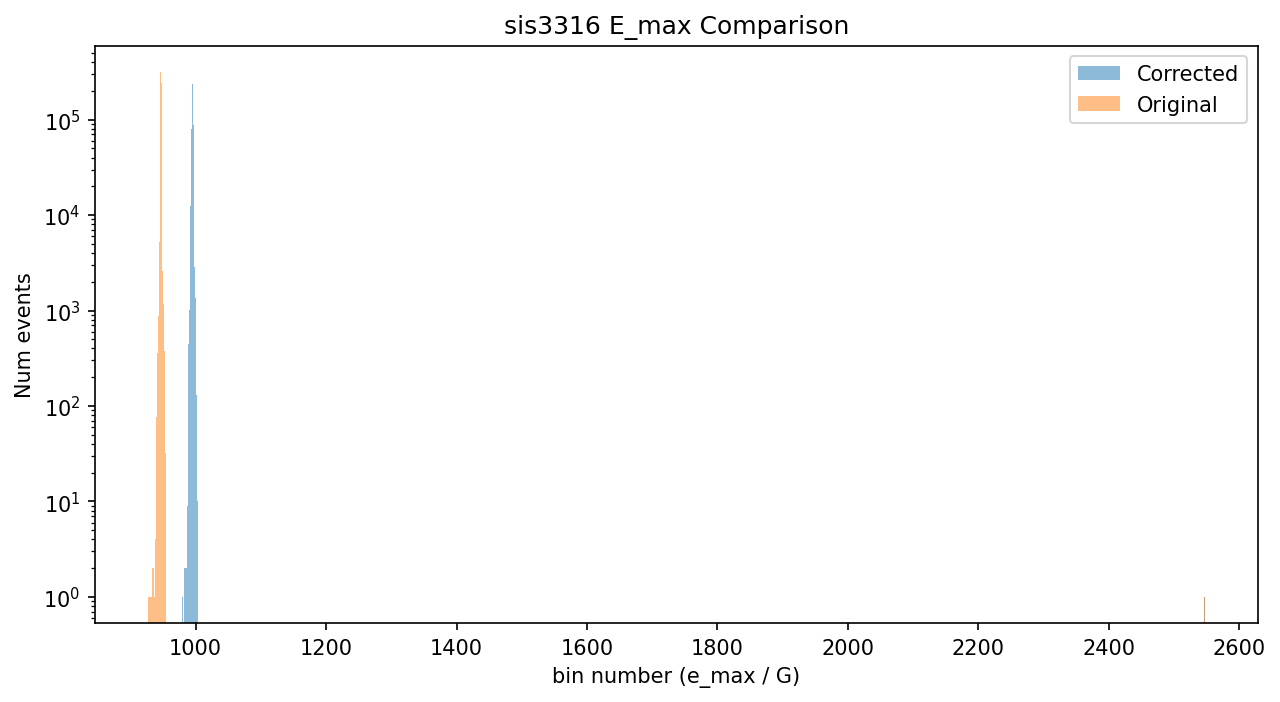

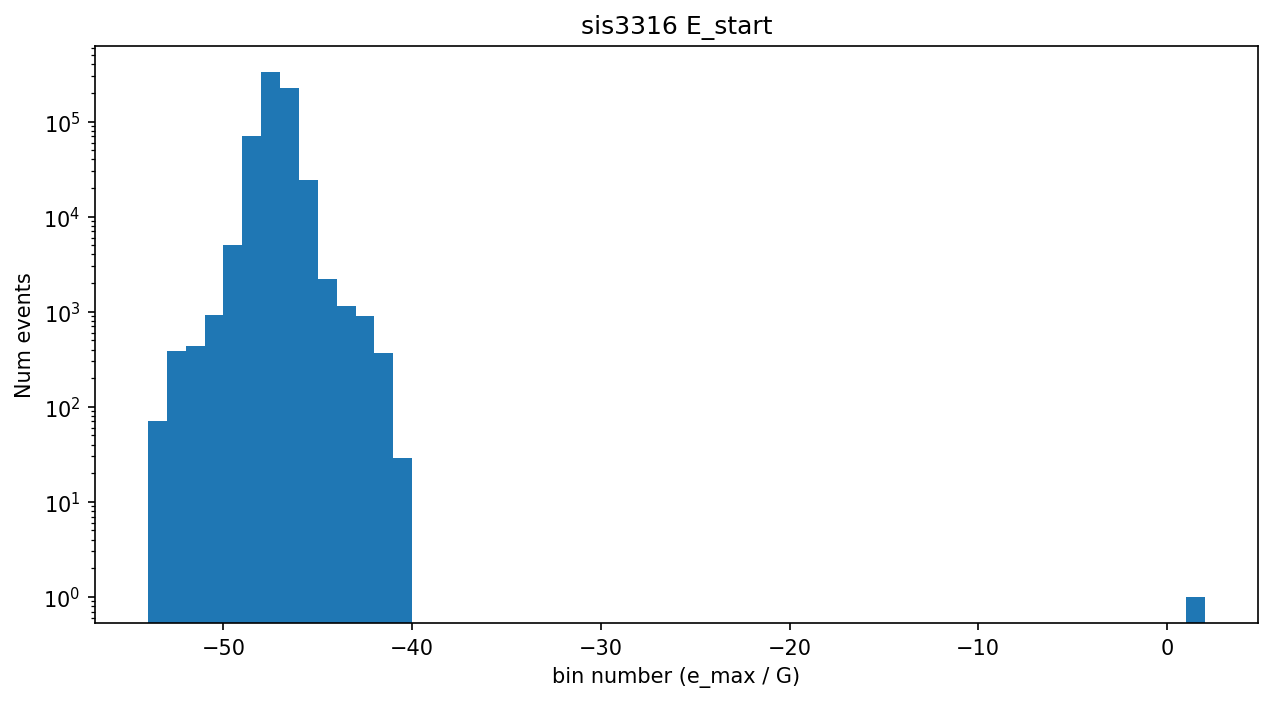

In [30]:
filename = "./Tests/20250616_run3/ch00.dat"
parse_events(filename, debug=True, save_raw=False)

Total events:  69392


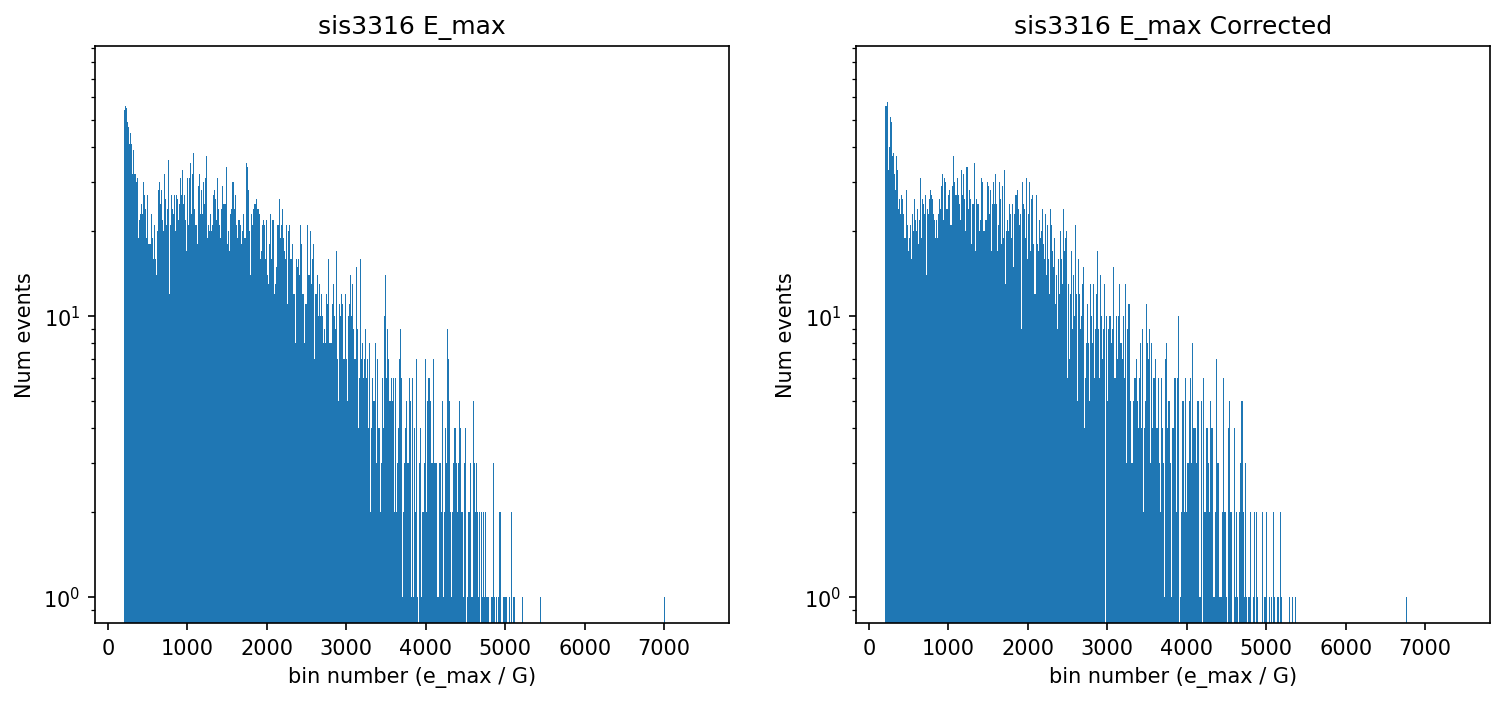

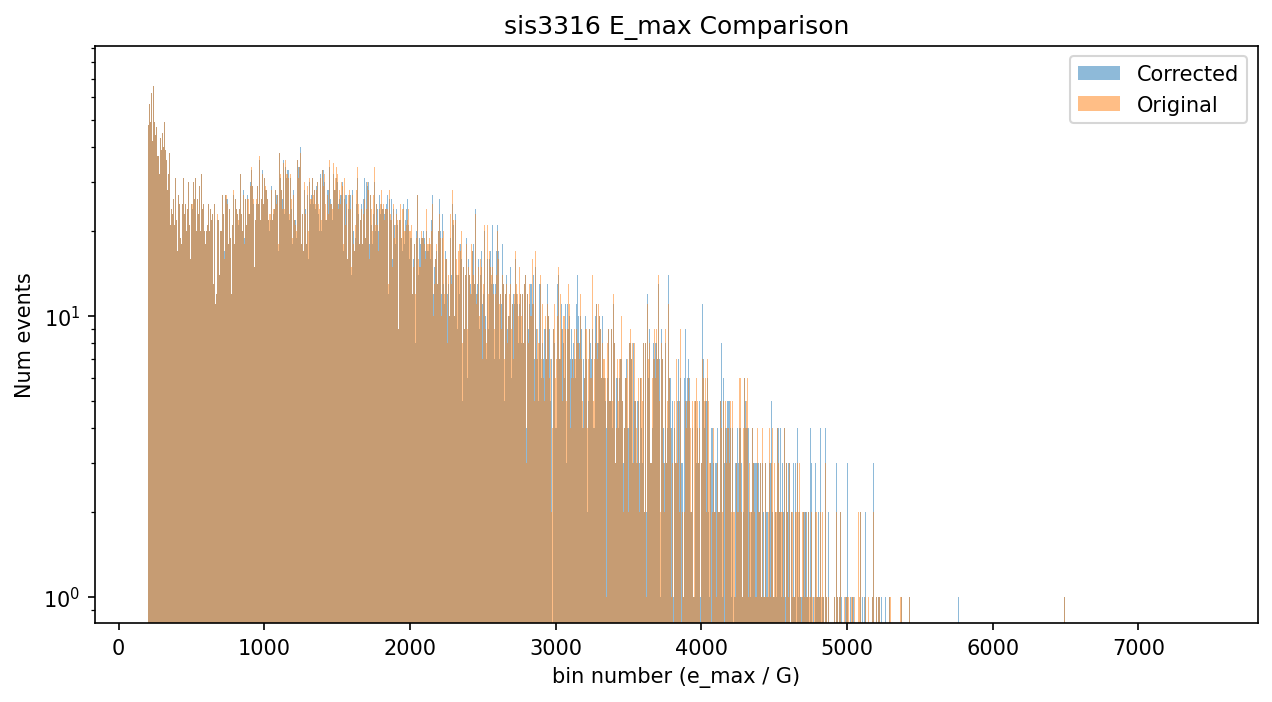

In [47]:
filename = "./Tests/20250610_run17/ch00.dat"
parse_events(filename, debug=False, save_raw=False)

Total events:  49143


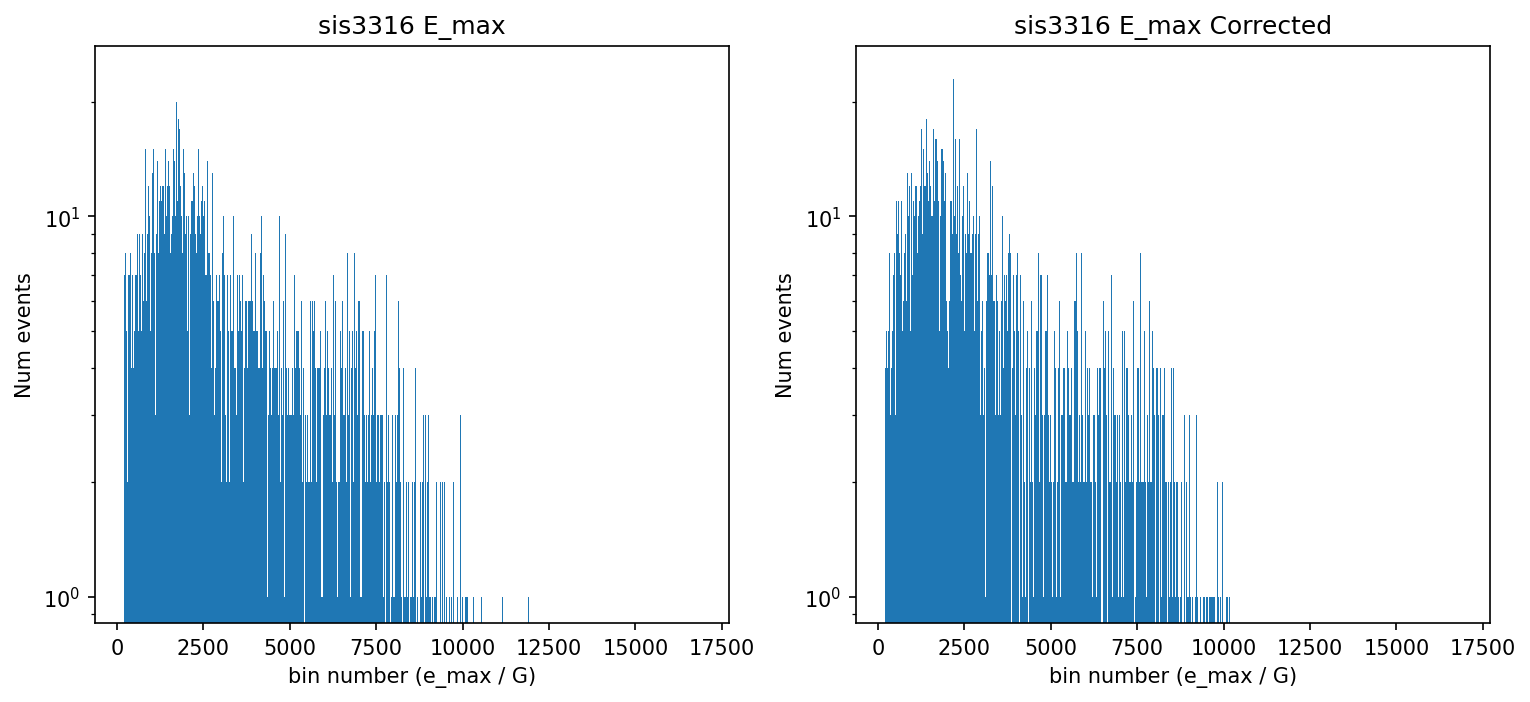

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x768596f97f80>>
Traceback (most recent call last):
  File "/home/dereksu2/Desktop/sis3316_gui/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


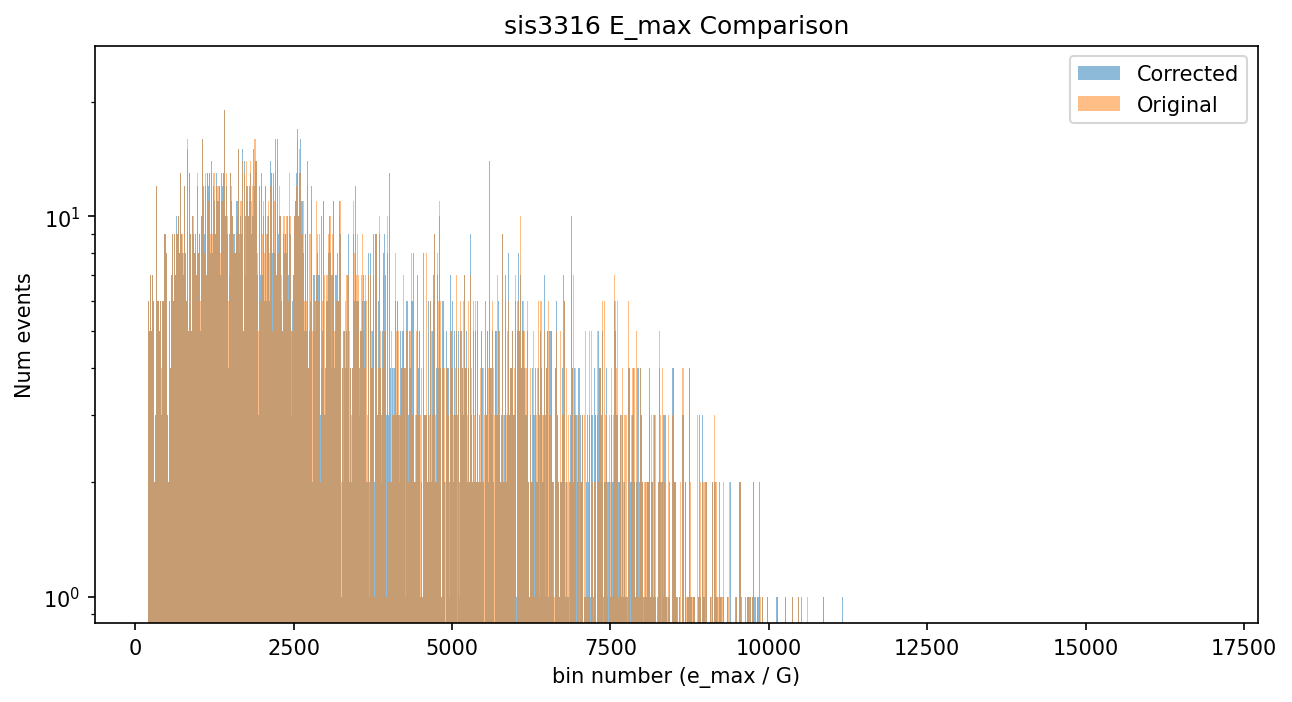

In [44]:
filename = "./Tests/20250610_run18/ch00.dat"
# filename = "./Tests/20250402_run14/ch00.dat"
# filename = "./Tests/20250327_run24/ch00.dat"
parse_events(filename, debug=False, save_raw=False)

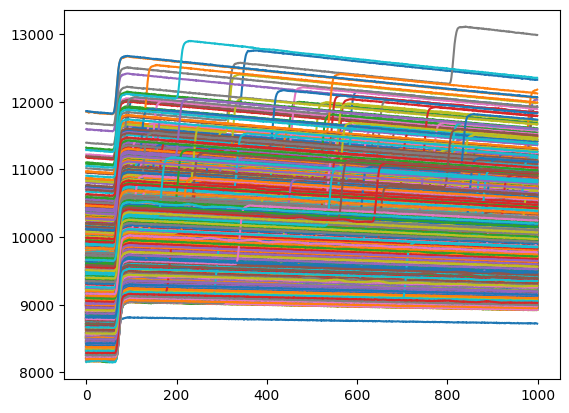

In [12]:
save_file_name = "./Tests/20250409_run4/ch00_raw.npy"

waveforms = np.load(save_file_name)
plt.plot(waveforms.T)
plt.show()